# DSA4264 Individual Assignment 2
**Name: Lim Zhi Xin** <br> **Matric Number: A0259553U** <br> **Github Repo:[https://github.com/zhixin-lim/DSA4262]**

## 1. Introduction

This notebook investigates the task of detecting stress in social media posts using the Dreaddit dataset. The objective is to develop and compare multiple modelling approaches, ranging from structured linguistic features to contextual transformer-based representations, in order to understand how stress is expressed in natural language. Beyond predictive performance, this analysis aims to extract meaningful insights about the linguistic and contextual patterns associated with psychological stress.


In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import torch
import re

# Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler


# Transformers
from transformers import (
    DistilBertTokenizer,
    DistilBertForSequenceClassification,
    TrainingArguments,
    Trainer
)

# Datasets
from datasets import Dataset

# Reproducibility
SEED = 42 # random seed for reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.backends.mps.is_available():
    torch.mps.manual_seed(SEED)

/Users/zhixin/Documents/y4s2/dsa4262/indiv assignment 2/nlp_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Exploratory Data Analysis

Before building predictive models, we first examine the distributional and linguistic characteristics of the dataset. This exploratory analysis focuses on:

- Class balance (stress vs non-stress)
- Subreddit-level variation in stress prevalence
- Annotation confidence levels
- Linguistic patterns such as sentiment, pronoun usage, and post length

The goal of this section is not only to understand the dataset structure, but also to identify patterns that may inform modelling decisions and interpretation of results.

### 2.1. Data Overview

In [2]:
# Load the Dreaddit dataset
train_data = pd.read_csv("data/dreaddit-train.csv")
test_data = pd.read_csv("data/dreaddit-test.csv")

print("Training shape:", train_data.shape)
print("Test shape:", test_data.shape)

# Missing value check
print("Missing values in training:", train_data.isnull().sum().sum())
print("Missing values in test:", test_data.isnull().sum().sum())

Training shape: (2838, 116)
Test shape: (715, 116)
Missing values in training: 0
Missing values in test: 0


No missing values were detected in either the training or test datasets. Therefore, no imputation or row removal was required prior to analysis.

### 2.2. Class Balance

In [3]:
# Class Distribution for Training Data
class_counts = train_data['label'].value_counts().sort_index()
class_percentages = train_data['label'].value_counts(normalize=True).sort_index()

class_distribution = pd.DataFrame({
    "Count": class_counts,
    "Proportion": class_percentages.round(3)
})

class_distribution

,Count,Proportion
label,,
0,1350,0.476
1,1488,0.524


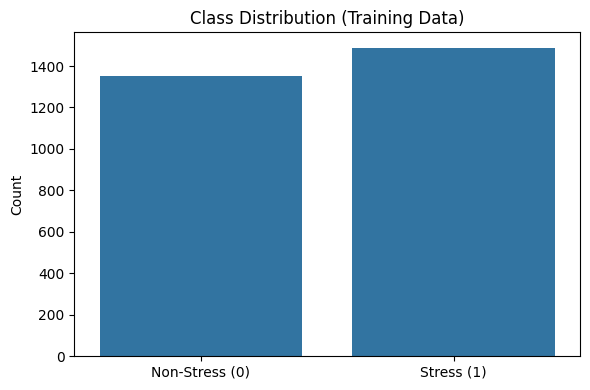

In [4]:
# Visualize the distribution of stressed vs non-stressed segments
plt.figure(figsize=(6,4))

sns.countplot(data=train_data, x='label')

plt.title("Class Distribution (Training Data)")
plt.xticks([0,1], ["Non-Stress (0)", "Stress (1)"])
plt.ylabel("Count")
plt.xlabel("")
plt.tight_layout()
plt.show()

The training dataset contains 2,838 labeled segments, with approximately 52% labeled as stressed and 48% labeled as non-stressed. The near-balanced distribution reduces the risk of severe class imbalance bias. Consequently, the F1-score is an appropriate evaluation metric for this task.

In [5]:
# Class Distribution for Test Data
test_counts = test_data['label'].value_counts().sort_index()
test_percentages = test_data['label'].value_counts(normalize=True).sort_index()

test_distribution_table = pd.DataFrame({
    "Count": test_counts,
    "Proportion": test_percentages.round(3)
})

test_distribution_table

,Count,Proportion
label,,
0,346,0.484
1,369,0.516


The test set exhibits a similar class distribution to the training set and contains no missing values, suggesting that both splits are comparably structured.

### 2.3. Subreddit Distribution

The Dreaddit dataset contains posts drawn from 10 subreddits spanning multiple thematic domains (e.g., trauma, anxiety, relationships, and financial hardship). Understanding subreddit-level distribution is important because domain imbalance may influence linguistic patterns and downstream model performance.

In [6]:
# Subreddit Distribution in Training Data
sub_counts = train_data['subreddit'].value_counts().sort_values(ascending=False)

subreddit_distribution = pd.DataFrame({
    "Count": sub_counts,
    "Proportion": (sub_counts / len(train_data)).round(3)
})

subreddit_distribution

,Count,Proportion
subreddit,,
ptsd,584,0.206
relationships,552,0.195
anxiety,503,0.177
domesticviolence,316,0.111
assistance,289,0.102
survivorsofabuse,245,0.086
homeless,168,0.059
almosthomeless,80,0.028
stress,64,0.023


The dataset spans 10 subreddits with uneven representation. Communities such as ptsd, relationships, and anxiety contain the largest number of posts, whereas stress and food_pantry are under-represented. This imbalance may influence model learning, as classifiers trained on larger subreddits may capture domain-specific patterns more reliably than those from smaller communities.

In [7]:
# Stress Proportion by Subreddit
subreddit_stress = (
    train_data
    .groupby('subreddit')['label']
    .mean()
    .sort_values(ascending=False)
)

subreddit_stress_table = subreddit_stress.reset_index()
subreddit_stress_table.columns = ["Subreddit", "Stress Proportion"]

subreddit_stress_table

,Subreddit,Stress Proportion
0,anxiety,0.658052
1,domesticviolence,0.639241
2,almosthomeless,0.587500
3,ptsd,0.568493
4,stress,0.546875
5,survivorsofabuse,0.457143
6,relationships,0.447464
7,food_pantry,0.378378
8,homeless,0.375000
9,assistance,0.363322


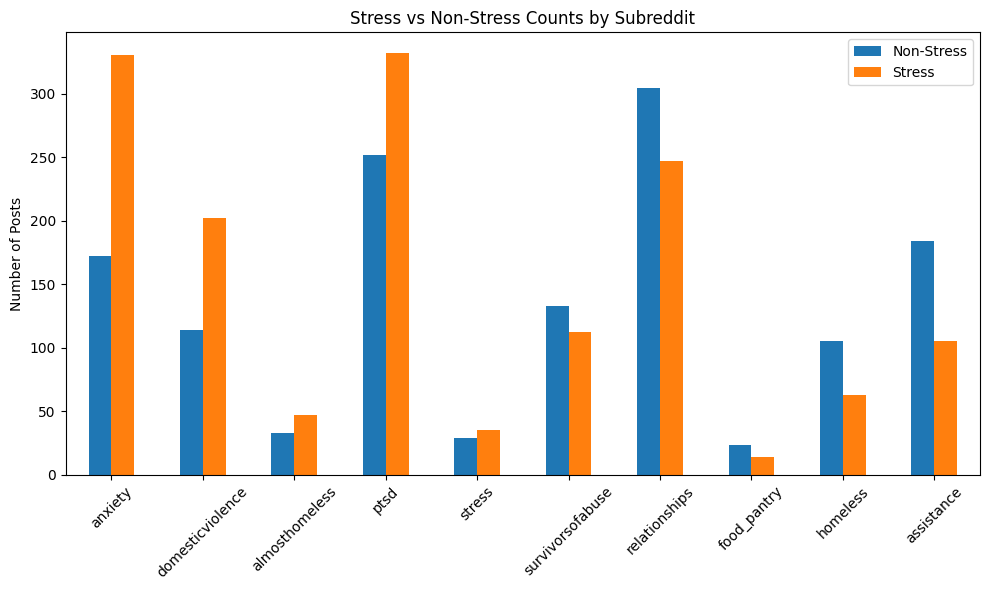

In [8]:
# Visualization of Stress Proportion by Subreddit
subreddit_counts = (
    train_data
    .groupby(['subreddit', 'label'])
    .size()
    .unstack()
    .loc[subreddit_stress.index]
)

subreddit_counts.plot(kind='bar', figsize=(10,6))

plt.title("Stress vs Non-Stress Counts by Subreddit")
plt.ylabel("Number of Posts")
plt.xlabel("")
plt.xticks(rotation=45)
plt.legend(["Non-Stress", "Stress"])
plt.tight_layout()
plt.show()

Stress prevalence varies substantially across subreddits. Communities centered around psychological distress, such as anxiety and domesticviolence, exhibit the highest proportions of stressed posts. In contrast, financially oriented communities such as assistance and homeless show comparatively lower stress proportions.

This pattern suggests that stress expression is domain-dependent. In mental health–focused communities, users may explicitly articulate emotional strain, whereas in financial assistance communities, posts may emphasize practical needs without directly expressing psychological distress. These domain differences may influence model performance, as lexical cues for stress may be more salient in some contexts than others.

### 2.4. Annotation Confidence

Each post in the Dreaddit dataset is accompanied by an annotator agreement score reflecting the proportion of raters who assigned the same label. Examining confidence levels provides insight into the inherent ambiguity of stress detection and helps contextualize model performance limits.

In [9]:
# Categorize Annotation Confidence Levels
def categorize_confidence(x):
    if x == 1.0:
        return "Perfect (100%)"
    elif x >= 0.8:
        return "High (≥80%)"
    elif x >= 0.6:
        return "Moderate (≥60%)"
    else:
        return "Low (<60%)"

train_data['confidence_level'] = train_data['confidence'].apply(categorize_confidence)

confidence_table = (
    train_data['confidence_level']
    .value_counts(normalize=True)
    .mul(100)
    .round(2)
    .reset_index()
)

confidence_table.columns = ["Agreement Level", "Percentage"]

confidence_table

/var/folders/z9/41w961mj1jnffsfx31fd6z5m0000gn/T/ipykernel_54159/609113139.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_data['confidence_level'] = train_data['confidence'].apply(categorize_confidence)


,Agreement Level,Percentage
0,Perfect (100%),39.75
1,High (≥80%),25.51
2,Moderate (≥60%),20.47
3,Low (<60%),14.27


Approximately 40% of the dataset exhibits perfect annotator agreement. An additional quarter falls within the high agreement (≥80%) category, while roughly one-third of posts reflect moderate or low agreement.

This distribution indicates that although many posts present clear stress signals, a substantial portion of the dataset contains ambiguous or context-dependent expressions. Therefore, model performance may be partially constrained by inherent labeling uncertainty rather than purely modelling limitations.

In [10]:
# Confidence by Label
confidence_by_label = (
    train_data
    .groupby('label')['confidence']
    .agg(['mean', 'median', 'std'])
    .round(3)
)

confidence_by_label

,mean,median,std
label,,,
0,0.805,0.8,0.180
1,0.813,0.8,0.175


Mean annotation confidence is similar across classes (Non-Stress ≈ 0.805; Stress ≈ 0.813), with identical medians. This suggests that labeling ambiguity is not disproportionately associated with either class. Consequently, classification difficulty is unlikely to arise from asymmetric uncertainty between stress and non-stress samples.

### 2.5. Linguistic Patterns

To better understand how stress manifests in language, we examine several linguistic dimensions: sentiment polarity, post length, and pronoun usage. These features capture emotional tone, verbosity, and self-referential focus — all of which may be theoretically linked to psychological stress.

#### 2.5.1. Sentiment

In [11]:
# Sentiment by Label
sentiment_summary = (
    train_data
    .groupby('label')['sentiment']
    .agg(['mean', 'median', 'std'])
    .round(3)
)

sentiment_summary

,mean,median,std
label,,,
0,0.103,0.107,0.180
1,-0.016,-0.008,0.191


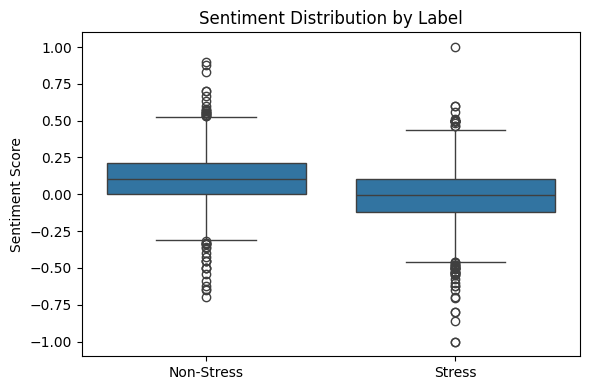

In [12]:
# Visualization of Sentiment Distribution by Label
plt.figure(figsize=(6,4))

sns.boxplot(x='label', y='sentiment', data=train_data)

plt.xticks([0,1], ['Non-Stress', 'Stress'])
plt.title("Sentiment Distribution by Label")
plt.xlabel("")
plt.ylabel("Sentiment Score")
plt.tight_layout()
plt.show()

Non-stressed segments exhibit more positive sentiment on average (mean ≈ 0.10), whereas stressed segments are slightly negative or near-neutral (mean ≈ -0.02). However, stressed posts are not strongly negative overall. This suggests that stress detection cannot be reduced to simple sentiment classification and likely depends on more nuanced contextual or narrative patterns.

#### 2.5.2. Post Length

In [13]:
# Post Length Analysis for Training Data
train_data['word_count'] = train_data['text'].apply(lambda x: len(str(x).split()))

word_length_summary = (
    train_data
    .groupby('label')['word_count']
    .agg(['count', 'mean', 'median', 'std', 'min', 'max'])
    .round(1)
)

word_length_summary

/var/folders/z9/41w961mj1jnffsfx31fd6z5m0000gn/T/ipykernel_54159/1410834363.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_data['word_count'] = train_data['text'].apply(lambda x: len(str(x).split()))


,count,mean,median,std,min,max
label,,,,,,
0,1350,82.2,78.0,29.1,1,255
1,1488,88.8,83.0,34.6,1,310


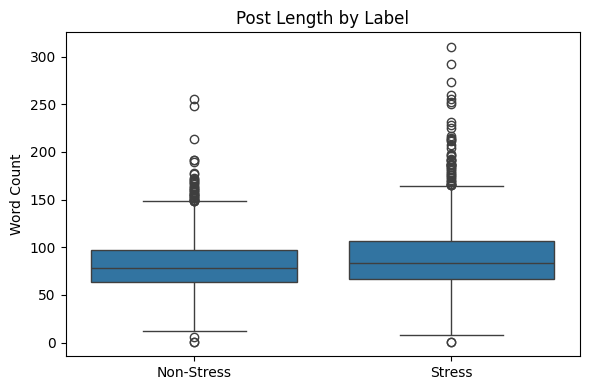

In [14]:
# Visualization of Post Length by Label
plt.figure(figsize=(6,4))

sns.boxplot(x='label', y='word_count', data=train_data)

plt.xticks([0,1], ['Non-Stress', 'Stress'])
plt.title("Post Length by Label")
plt.xlabel("")
plt.ylabel("Word Count")
plt.tight_layout()
plt.show()

Stressed segments are modestly longer than non-stressed segments (mean ≈ 88.8 vs. 82.2 words) and exhibit greater variability. While the difference in central tendency is not substantial, the pattern suggests that stress expression may involve slightly more elaboration or contextual detail. However, post length alone is unlikely to serve as a strong discriminative feature.

#### 2.5.3. Pronoun Usage

In [15]:
# Pronoun Usage
pronoun_stats = (
    train_data
    .groupby('label')[['lex_liwc_i', 'lex_liwc_we']]
    .agg(['mean', 'median', 'std', 'min', 'max'])
    .round(3)
)

pronoun_stats

lex_liwc_i                           lex_liwc_we                     \
            mean median    std  min    max        mean median    std  min   
label                                                                       
0          7.110   7.07  4.518  0.0  27.78       0.997    0.0  1.790  0.0   
1         10.841  10.99  4.022  0.0  30.00       0.554    0.0  1.292  0.0   

              
         max  
label         
0      12.96  
1      12.77

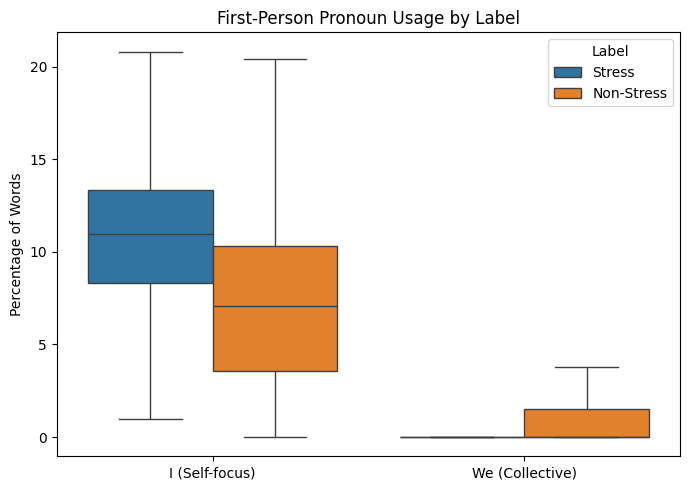

In [16]:
# Visualization of First-Person Pronoun Usage by Label
pronoun_long = train_data.melt(
    id_vars='label',
    value_vars=['lex_liwc_i', 'lex_liwc_we'],
    var_name='Pronoun',
    value_name='Proportion'
)

pronoun_long['Label'] = pronoun_long['label'].map({0: 'Non-Stress', 1: 'Stress'})
pronoun_long['Pronoun'] = pronoun_long['Pronoun'].map({
    'lex_liwc_i': 'I (Self-focus)',
    'lex_liwc_we': 'We (Collective)'
})

plt.figure(figsize=(7,5))

sns.boxplot(
    x='Pronoun',
    y='Proportion',
    hue='Label',
    data=pronoun_long,
    showfliers=False
)

plt.title("First-Person Pronoun Usage by Label")
plt.ylabel("Percentage of Words")
plt.xlabel("")
plt.tight_layout()
plt.show()

Stressed segments exhibit substantially higher first-person singular pronoun usage (mean ≈ 10.84%) compared to non-stressed segments (mean ≈ 7.11%). In contrast, collective pronoun usage (“we”) is sparse across both classes, with median values of zero.

The increased use of “I” suggests heightened self-focus in stressed posts, aligning with psychological theories linking rumination and inward attention to emotional distress (Edwards & Holtzman, 2017).

Overall, these linguistic patterns suggest that stress expression is multifaceted and cannot be captured by a single surface-level indicator. This motivates the exploration of increasingly expressive modelling approaches in the next section.

## 3. Preprocessing

Given the informal and expressive nature of Reddit posts, preprocessing decisions were made conservatively to preserve meaningful linguistic cues. Excessive normalization (e.g., aggressive stopword removal or lemmatization) may eliminate psychologically informative features such as pronoun usage, tone, or stylistic emphasis.

### 3.1. Missing Values
As established in Section 2.1, no missing text entries were detected. Therefore, no imputation was required.

### 3.2. URL Removal

In [17]:
# URL Handling
url_pattern = r'http\S+|www\.\S+'

train_data['has_url'] = train_data['text'].apply(
    lambda x: bool(re.search(url_pattern, str(x)))
)

train_data['has_url'].value_counts()

/var/folders/z9/41w961mj1jnffsfx31fd6z5m0000gn/T/ipykernel_54159/839447805.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_data['has_url'] = train_data['text'].apply(


has_url
False    2837
True        1
Name: count, dtype: int64

In [18]:
# Manual Inspection of Posts Containing URLs
train_data[train_data['has_url'] == True][['text', 'label']].head()

,text,label
2758,"Most diagnoses, except those relating to the e...",0


In [19]:
# Remove URLs from text data
def remove_urls(text):
    url_pattern = r'http\S+|www\.\S+'
    return re.sub(url_pattern, '', text)
train_data['text'] = train_data['text'].apply(remove_urls)

A small proportion of posts contained URLs. Because URLs do not contribute meaningful psychological or linguistic information for stress detection, they were removed to reduce non-linguistic noise. No additional text normalization (e.g., stopword removal, lemmatization, or punctuation stripping) was applied.

Stopwords were intentionally retained, as exploratory analysis revealed that pronoun usage, particularly first-person singular forms, is associated with stress expression. Furthermore, contextual transformer models rely on raw token sequences and may benefit from preserving casing, punctuation, and stylistic variation.

Because the goal is to capture authentic stress expression, preserving natural language structure is more important than aggressive normalization.

## 4. Modelling Approaches

To evaluate how different levels of linguistic representation affect stress detection, three modelling paradigms are explored:

- **Structured Feature Model** — leveraging handcrafted linguistic and social features
- **TF-IDF + Logistic Regression** — surface lexical representation
- **Fine-tuned DistilBERT** — contextual transformer-based modelling

This progression allows us to compare engineered features, bag-of-words representations, and deep contextual embeddings.

### 4.1. Structured Feature Model

The structured feature model leverages pre-computed linguistic, syntactic, and social media features included in the dataset *(e.g., LIWC categories, readability indices, sentiment scores)*. These features capture psychologically motivated signals without directly modelling raw text.

This model serves as a baseline to evaluate how much predictive signal exists in engineered linguistic features alone.

In [20]:
# Structured Feature Selection
# Add word_count to both datasets
train_data['word_count'] = train_data['text'].apply(lambda x: len(str(x).split()))
test_data['word_count'] = test_data['text'].apply(lambda x: len(str(x).split()))

# Select numeric columns
numeric_cols = train_data.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Explicitly remove leakage / non-linguistic features
cols_to_exclude = [
    'label',
    'confidence',       # remove annotation metadata
]

structured_features = [
    col for col in numeric_cols
    if col not in cols_to_exclude
]

print("Number of structured features:", len(structured_features))

/var/folders/z9/41w961mj1jnffsfx31fd6z5m0000gn/T/ipykernel_54159/2636896113.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_data['word_count'] = test_data['text'].apply(lambda x: len(str(x).split()))


Number of structured features: 111


In [21]:
X_train_struct = train_data[structured_features]
X_test_struct = test_data[structured_features]

y_train = train_data['label']
y_test = test_data['label']

To avoid information leakage, only features obtainable from the raw post content were retained. Annotation-derived variables and post-hoc metadata were excluded, as they would not be available in real-world deployment scenarios.

In [22]:
# Since structured features are on different scales (e.g., LIWC percentages vs word counts)
# standardization is applied to ensure that all features contribute equally to the model training. 
# This prevents features with larger numeric ranges from dominating the learning process and allows the logistic regression model to converge more effectively.

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_struct)
X_test_scaled = scaler.transform(X_test_struct)

In [23]:
# Train Logistic Regression on Structured Features
struct_model = LogisticRegression(
    max_iter=2000,
    class_weight='balanced',
    random_state=SEED
)

struct_model.fit(X_train_scaled, y_train)

y_pred_struct = struct_model.predict(X_test_scaled)

print("Structured Model Test F1:", round(f1_score(y_test, y_pred_struct), 3))
print(classification_report(y_test, y_pred_struct))

Structured Model Test F1: 0.756
              precision    recall  f1-score   support

           0       0.74      0.72      0.73       346
           1       0.74      0.77      0.76       369

    accuracy                           0.74       715
   macro avg       0.74      0.74      0.74       715
weighted avg       0.74      0.74      0.74       715



In [24]:
# Extract Important Structured Predictors
coefficients = struct_model.coef_[0]

feature_importance = pd.DataFrame({
    "Feature": structured_features,
    "Coefficient": coefficients
})

# Sort by absolute importance
feature_importance["Abs_Coefficient"] = feature_importance["Coefficient"].abs()

feature_importance_sorted = feature_importance.sort_values(
    by="Abs_Coefficient",
    ascending=False
)

feature_importance_sorted.head(15)

,Feature,Coefficient,Abs_Coefficient
12,lex_liwc_function,1.022953,1.022953
33,lex_liwc_affect,0.727600,0.727600
35,lex_liwc_negemo,-0.725360,0.725360
23,lex_liwc_auxverb,-0.539827,0.539827
54,lex_liwc_feel,0.510334,0.510334
6,lex_liwc_Clout,-0.486870,0.486870
21,lex_liwc_article,-0.456716,0.456716
51,lex_liwc_percept,-0.432223,0.432223
8,lex_liwc_Tone,-0.406686,0.406686
50,lex_liwc_differ,-0.393695,0.393695


The structured feature model achieved a test F1 score of 0.756, indicating that engineered linguistic and psychological features alone capture substantial signal for stress detection. 

**Features positively associated with stress:**
- lex_liwc_function → higher density of function words
- lex_liwc_affect → more emotion-related words
- lex_liwc_feel → more explicit feeling words
- lex_liwc_Apostro → more contractions (e.g., "I'm", "don't")

Interpretation:
- Stressed posts tend to contain more emotional language.
- They use more conversational phrasing (contractions).
- They may involve more personal narrative style.

Interestingly, certain polarity-based features such as lex_liwc_negemo, lex_liwc_posemo, and overall Tone were negatively associated with stress. This indicates that stress detection is not driven purely by overt positive or negative emotion words. Rather, stress appears to be reflected in broader patterns of emotional density and personal expression rather than simple emotional polarity.

This aligns with earlier exploratory findings, which showed that stress expression is often nuanced and not always strongly negative in sentiment.

### 4.2. TF-IDF + Logistic Regression Model

As a surface-level lexical baseline, we apply TF-IDF vectorization with logistic regression. Unlike the structured feature model, which relies on predefined psychological categories, TF-IDF captures discriminative n-grams directly from raw text. This model evaluates how well stress can be detected using purely lexical frequency patterns without contextual embedding.

In [25]:
# TF-IDF + Logistic Regression Pipeline
tfidf_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        ngram_range=(1,2),        # chosen to capture both unigrams and bigrams for richer lexical representation
        max_features=5000
    )),
    ("clf", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        random_state=SEED
    ))
])

In [26]:
# Cross-validation on training data
cv_scores = cross_val_score(
    tfidf_pipeline,
    train_data["text"],
    train_data["label"],
    cv=5,
    scoring="f1"
)

print("TF-IDF CV F1: {:.3f} ± {:.3f}".format(
    cv_scores.mean(),
    cv_scores.std()
))

TF-IDF CV F1: 0.767 ± 0.017


In [27]:
# Train on Full Training Data
tfidf_pipeline.fit(train_data["text"], train_data["label"])

y_pred_tfidf = tfidf_pipeline.predict(test_data["text"])

print("TF-IDF Test F1:", round(f1_score(test_data["label"], y_pred_tfidf), 3))
print(classification_report(test_data["label"], y_pred_tfidf))

TF-IDF Test F1: 0.74
              precision    recall  f1-score   support

           0       0.72      0.71      0.72       346
           1       0.73      0.75      0.74       369

    accuracy                           0.73       715
   macro avg       0.73      0.73      0.73       715
weighted avg       0.73      0.73      0.73       715



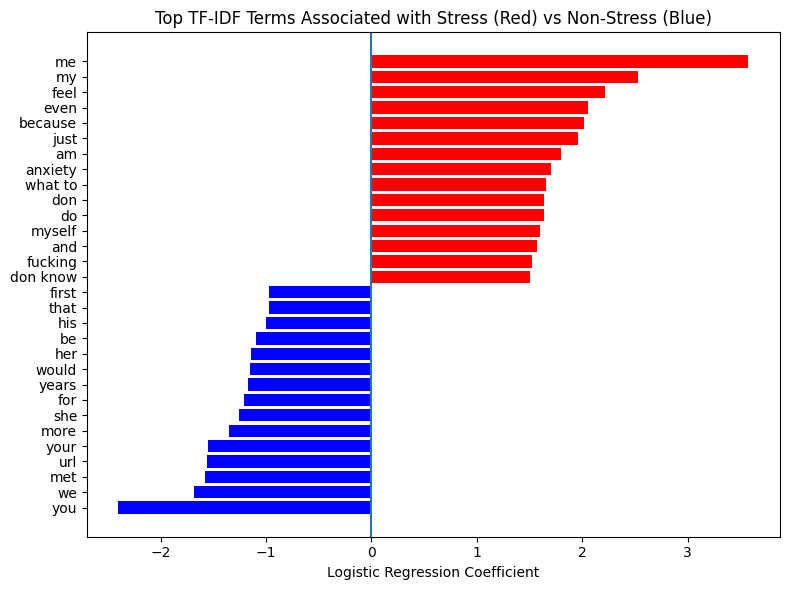

In [28]:
# Extract important words from TF-IDF model

# Get feature names
feature_names = tfidf_pipeline.named_steps["tfidf"].get_feature_names_out()

# Get coefficients
coefficients = tfidf_pipeline.named_steps["clf"].coef_[0]

tfidf_importance = pd.DataFrame({
    "Term": feature_names,
    "Coefficient": coefficients
})

# Select top terms
top_n = 15

stress_terms = tfidf_importance.sort_values(
    by="Coefficient",
    ascending=False
).head(top_n)

nonstress_terms = tfidf_importance.sort_values(
    by="Coefficient",
    ascending=True
).head(top_n)

# Combine
combined = pd.concat([nonstress_terms, stress_terms])

# Sort by coefficient
combined = combined.sort_values(by="Coefficient")

colors = ["red" if c > 0 else "blue" for c in combined["Coefficient"]]

plt.figure(figsize=(8,6))
plt.barh(combined["Term"], combined["Coefficient"], color=colors)
plt.axvline(0)

plt.title("Top TF-IDF Terms Associated with Stress (Red) vs Non-Stress (Blue)")
plt.xlabel("Logistic Regression Coefficient")
plt.tight_layout()
plt.show()

The TF-IDF model achieved a test F1 score of 0.74, slightly below the structured feature model. 

Examination of the most predictive terms reveals that stress predictions are strongly associated with first-person pronouns (“me”, “my”, “myself”) and emotional or cognitive markers (“feel”, “anxiety”, “don’t know”, “because”).
In contrast, non-stress predictions are more strongly associated with second-person and collective pronouns (“you”, “we”, “your”), suggesting advice-giving or outward-focused discourse.

While many of the top coefficients correspond to high-frequency function words or pronouns, these terms are not arbitrary. Their prominence reflects systematic differences in discourse structure. Stressed posts tend to be self-focused and introspective, whereas non-stressed posts more often adopt an outward or advisory tone. Thus, even seemingly simple words capture meaningful stylistic patterns.

### 4.3. Fine-tuned DistilBERT

To capture contextual and semantic nuances beyond surface lexical patterns, we fine-tune a pre-trained transformer model, DistilBERT. Unlike TF-IDF, which treats words as independent tokens, DistilBERT encodes contextual relationships between words, allowing it to model subtle and indirect expressions of stress.

In [29]:
# Splitting data into training, validation, and test sets for transformer model
train_split, val_split = train_test_split(
    train_data,
    test_size=0.2,
    random_state=SEED,
    stratify=train_data["label"]
)
print("Train size:", len(train_split))
print("Validation size:", len(val_split))

Train size: 2270
Validation size: 568


In [30]:
# Convert to Hugging Face Datasets format
train_dataset = Dataset.from_dict({
    "text": train_split["text"].tolist(),
    "label": train_split["label"].tolist()
})

val_dataset = Dataset.from_dict({
    "text": val_split["text"].tolist(),
    "label": val_split["label"].tolist()
})

test_dataset = Dataset.from_dict({
    "text": test_data["text"].tolist(),
    "label": test_data["label"].tolist()
})

In [31]:
# Tokenization
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_function(example):
    return tokenizer(
        example["text"],
        truncation=True,
        padding="max_length",
        max_length=256
    )

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

Map: 100%|██████████| 715/715 [00:00<00:00, 19270.84 examples/s]


In [32]:
# Set format for PyTorch
train_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "label"]
)

val_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "label"]
)

test_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "label"]
)

In [33]:
# Load Model
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2
)

Loading weights: 100%|██████████| 100/100 [00:00<00:00, 2409.81it/s, Materializing param=distilbert.transformer.layer.5.sa_layer_norm.weight]   
DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_transform.weight  | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
pre_classifier.weight   | MISSING    | 
classifier.weight       | MISSING    | 
pre_classifier.bias     | MISSING    | 
classifier.bias         | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


In [34]:
# Training configuration
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=1)
    return {"f1": f1_score(labels, predictions)}

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    seed=SEED
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

In [35]:
# Train
trainer.train()

/Users/zhixin/Documents/y4s2/dsa4262/indiv assignment 2/nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


Epoch,Training Loss,Validation Loss,F1
1,No log,0.408460,0.814815
2,No log,0.417372,0.828523
3,No log,0.466290,0.836066


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  5.25it/s]
/Users/zhixin/Documents/y4s2/dsa4262/indiv assignment 2/nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)
Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]
/Users/zhixin/Documents/y4s2/dsa4262/indiv assignment 2/nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)
Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  4.18it/s]
There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.

TrainOutput(global_step=426, training_loss=0.34824425066021125, metrics={'train_runtime': 503.7556, 'train_samples_per_second': 13.518, 'train_steps_per_second': 0.846, 'total_flos': 451051492423680.0, 'train_loss': 0.34824425066021125, 'epoch': 3.0})

In [36]:
# Evaluate on test set
test_results = trainer.evaluate(test_dataset)
print(test_results)

/Users/zhixin/Documents/y4s2/dsa4262/indiv assignment 2/nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


{'eval_loss': 0.534384548664093, 'eval_f1': 0.8235294117647058, 'eval_runtime': 16.5204, 'eval_samples_per_second': 43.28, 'eval_steps_per_second': 2.724, 'epoch': 3.0}


DistilBERT was fine-tuned using an 80/20 train-validation split from the official training data. The best checkpoint was selected based on validation F1 score. The final model achieved a test F1 score of approximately 0.82, outperforming both the structured feature model (0.756) and the TF-IDF baseline (0.74).

The improvement suggests that contextual language representations capture nuanced semantic and discourse-level signals that are not fully captured by surface n-grams or predefined linguistic categories. The close alignment between validation and test performance indicates stable generalization without severe overfitting.

### Model Comparisons

In [37]:
model_comparison = pd.DataFrame({
    "Model": [
        "Structured Features (LR)",
        "TF-IDF + Logistic Regression",
        "DistilBERT (Fine-tuned)"
    ],
    "Validation F1": [
        None,              # structured had no separate validation
        None,              # tf-idf used CV instead
        0.836              # best validation F1 from epoch 3
    ],
    "Test F1": [
        0.756,
        0.740,
        0.824
    ]
})

model_comparison

,Model,Validation F1,Test F1
0,Structured Features (LR),NaN,0.756
1,TF-IDF + Logistic Regression,NaN,0.740
2,DistilBERT (Fine-tuned),0.836,0.824


The comparison highlights a clear performance hierarchy, with DistilBERT achieving the highest F1 score, followed by the structured feature model and the TF-IDF baseline. While contextual modeling yields the strongest predictive performance, the relatively competitive performance of the structured model suggests that psychologically motivated linguistic features alone capture substantial signal. This indicates that stress expression manifests both through interpretable stylistic markers and deeper contextual semantics. The following section therefore examines where even the strongest model struggles, in order to better understand the limits of automated stress detection.

## 5. Error Analysis and Insights

In [38]:
# Get predictions on test set from DistilBERT model
predictions = trainer.predict(test_dataset)

# Extract predicted labels
y_pred = predictions.predictions.argmax(axis=1)

# Calculate confidence scores (softmax probabilities)
probs = torch.softmax(torch.tensor(predictions.predictions), dim=1).numpy()
confidence_scores = probs.max(axis=1)

/Users/zhixin/Documents/y4s2/dsa4262/indiv assignment 2/nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


In [39]:
analysis_df = test_data.copy().reset_index(drop=True)

analysis_df["pred_label"] = y_pred
analysis_df["confidence"] = confidence_scores

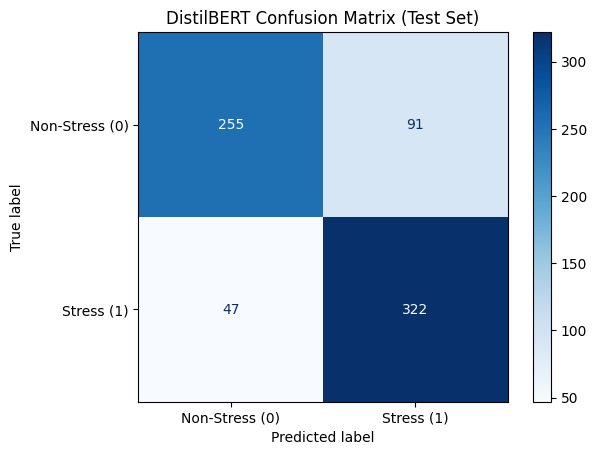

In [40]:
# Confusion matrix
cm = confusion_matrix(
    analysis_df["label"],
    analysis_df["pred_label"]
)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Non-Stress (0)", "Stress (1)"]
)

disp.plot(cmap="Blues")
plt.title("DistilBERT Confusion Matrix (Test Set)")
plt.show()

In [41]:
tn, fp, fn, tp = cm.ravel()

# Rates
tpr = tp / (tp + fn) * 100 if (tp + fn) > 0 else 0
tnr = tn / (tn + fp) * 100 if (tn + fp) > 0 else 0
fpr = fp / (fp + tn) * 100 if (fp + tn) > 0 else 0
fnr = fn / (fn + tp) * 100 if (fn + tp) > 0 else 0

print(f"True Negatives (TN): {tn} | TNR: {tnr:.3f}%")
print(f"False Positives (FP): {fp} | FPR: {fpr:.3f}%")
print(f"False Negatives (FN): {fn} | FNR: {fnr:.3f}%")
print(f"True Positives (TP): {tp} | TPR: {tpr:.3f}%")

True Negatives (TN): 255 | TNR: 73.699%
False Positives (FP): 91 | FPR: 26.301%
False Negatives (FN): 47 | FNR: 12.737%
True Positives (TP): 322 | TPR: 87.263%


The confusion matrix reveals that while DistilBERT performs strongly overall, prediction errors are not evenly distributed. The model produces more false positives (91) than false negatives (47), indicating a tendency to over-identify stress rather than under-detect it. Approximately 12.7% of true stress posts are missed, whereas 26.3% of non-stressed posts are incorrectly flagged as stress.

From a deployment perspective, this suggests that the model is somewhat risk-averse: it is more likely to over-flag stress than to miss it entirely. While over-flagging may create additional workload in real-world applications, missing genuinely stressed individuals carries potentially greater ethical and practical consequences. For this reason, the following sections focus first on **analysing the 47 missed stress cases.**

In [42]:
# False Negatives
false_negatives = analysis_df[
    (analysis_df["label"] == 1) &
    (analysis_df["pred_label"] == 0)
]

# True Positives
true_positives = analysis_df[
    (analysis_df["label"] == 1) &
    (analysis_df["pred_label"] == 1)
]

# Examples of False Negatives
pd.set_option('display.max_colwidth', None)
false_negatives[['text']].head(10)

,text
66,"Last week while my girlfriend was out of the country I noticed our puppy Luca wasn't acting himself. I took him to the emergency clinic and after some tests they told me he would require immediate surgery or we were at a high risk of losing him. The surgery was costly but necessary, however we are now having difficulty paying our bills. We have reached out to family and friends for support and are now searching for any help we can get. Thank you for taking the time to hear our story."
105,"Do you huddle up in the corner of some obscure building that's out of the way? Under a pine tree that's thick enough to prevent any outsiders knowing you're there? Those are kind of the best ideas I have... but I really don't know and I would greatly appreciate any advice. I don't want to give too many details but I live in a city of just over 100,000 people. I'm already on food and medical assistance."
139,"So I texted her a message saying “7:45” , I sent it with the quotations to let her know that she’s late and I’m starving. So F2 responds to me through her phone, by voice message. She gave me a very sassy attitude telling me to “remove the pipe from my ass and eat a snack”. I had already needed to eat a snack since they made me wait a half an hour, I don’t think that her response was warranted for what I said. I get what I said was a little petty but I don’t think I deserved that attitude."
151,"It's just us two and it's, really intense. She hugs me, tells me how much she's missed me. Reminisces about our relationship. Tells me how I broke her heart. She tells me about lads she's been with since and it felt like she was comparing them all to me and gets really emotional."
159,"Yeah, not so much. I had a minor surgery on my neck today that just used local anesthetic, so I was fully conscious for it. Everything was fine since I'm not squeamish - until I realized they needed to strap me down to make sure I didn't move. It's a delicate procedure; I understood. But I hadn't been in restraints since the medical trauma, and I completely dissociated."
168,"I don't mind the fact that she goes, I don't even mind if she goes at the same time as me. I just wish she wouldn't make such a big deal out of doing it together. How do I convey this to her without looking like a selfish asshole? **Tl;dr: I prefer to work out by myself for various reasons. My roommate decided to start going with me and is requesting that I make accommodations to my schedule and routine so that she can join me."
173,Maybe anyone with a history of abuse or trauma can tell me if there are particular things to be sensitive to here: I tried to be supportive but obviously failed in the end here. She's talking about wanting to divorce me. We're looking into couples therapy. I really appreciate any insight or advice. **TLDR**: Wife is working on an art piece that is important for her career in the arts non-profit world.
174,"He is our little angel and we are both gaga for him, but money has been extraordinary tight, adjusting to parent life and sleep deprivation has been tough for both of us. We were fighting and bickering a bit for the first time in his first months of life, but I figured that was normal for new parents. I work in the financial industry for a modest income (working hard currently to get to the next level where I'll make substantially more) and she works for an arts-based nonprofit. I have no particular attachment to the financial industry, it's just been a way to pay the bills and I find it interesting enough. She's a passionate artist though, always knew she wanted to be one, and it's really important to her."
175,"We met about 2.5 years ago, both somewhat fresh off our respective divorces. I felt we had a real connection, we fell for each other hard, dated (eventually lived together) for a little less than a year before she got pregnant. We were both really happy as we had both talked about wanting children - at the time we got pregnant we were ""not NOT

### 5.1. Characteristics of Missed Stress


In [43]:
print("FN Count:", len(false_negatives))
print("TP Count:", len(true_positives))

FN Count: 47
TP Count: 322


In [44]:
# Comparing Word Counts
print("Average Word Count (FN):",
    round(false_negatives["word_count"].mean(), 2))

print("Average Word Count (TP):",
    round(true_positives["word_count"].mean(), 2))

Average Word Count (FN): 89.74
Average Word Count (TP): 88.36


In [45]:
# Comparing Sentiment Scores
print("Average Sentiment (FN):",
    round(false_negatives["sentiment"].mean(), 3))
print("Average Sentiment (TP):",
    round(true_positives["sentiment"].mean(), 3))

Average Sentiment (FN): 0.079
Average Sentiment (TP): -0.028


In [46]:
# Compare Self-Focus
print("Average 'I' Usage (FN):",
    round(false_negatives["lex_liwc_i"].mean(), 3))
print("Average 'I' Usage (TP):",
    round(true_positives["lex_liwc_i"].mean(), 3))

Average 'I' Usage (FN): 8.69
Average 'I' Usage (TP): 11.109


A comparison between false negatives (missed stress cases) and true positives reveals several patterns.

- Post length is nearly identical between groups (FN: 89.74 words; TP: 88.36 words), indicating that missed stress is not associated with shorter or less detailed posts.

- Sentiment differs meaningfully: false negatives exhibit slightly positive or neutral tone on average (0.079), whereas true positives are slightly negative (−0.028). This suggests that the model more reliably detects stress when it is expressed with clearer emotional intensity or negative tone.

- Self-focus is substantially lower in false negatives (average “I” usage: 8.69%) compared to true positives (11.11%). This indicates that the model has learned to associate stress with heightened self-referential language.

Taken together, these findings suggest that the model is particularly sensitive to emotionally explicit and self-focused expressions of distress. When stress is conveyed in a more neutral tone or with less direct self-reference, the likelihood of misclassification increases.

### 5.2. Domain-Level Predictability

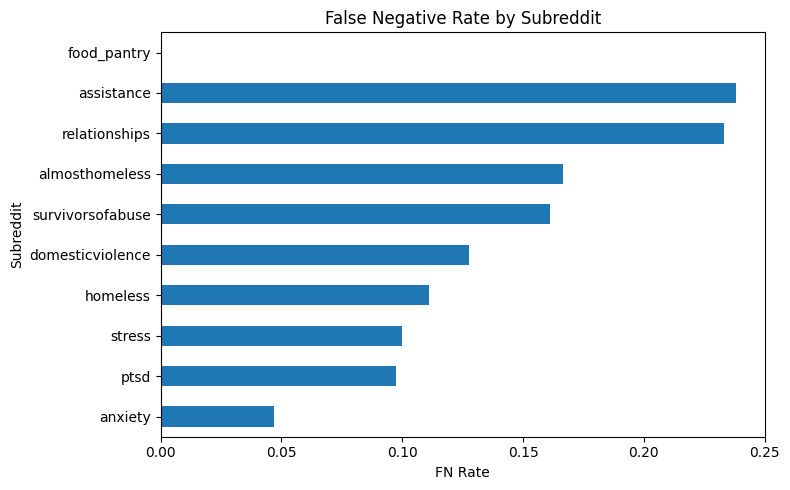

In [47]:
# Subreddit distribution of false negatives
# True stress posts overall
true_stress = analysis_df[
    analysis_df["label"] == 1
]

# FN counts by subreddit
fn_counts = false_negatives["subreddit"].value_counts()

# Total stress posts by subreddit
stress_counts = true_stress["subreddit"].value_counts()

# Compute FN rate per subreddit
fn_rate_by_sub = (fn_counts / stress_counts).sort_values(ascending=False)

fn_rate_by_sub.sort_values().plot(kind="barh", figsize=(8,5))

plt.title("False Negative Rate by Subreddit")
plt.xlabel("FN Rate")
plt.ylabel("Subreddit")
plt.tight_layout()
plt.show()


Earlier exploratory analysis showed substantial variation in both subreddit size and stress prevalence. Larger subreddits such as ptsd, relationships, and anxiety contributed a substantial portion of training data, potentially allowing the model greater exposure to their linguistic patterns. Additionally, stress prevalence varied widely across domains, with communities such as anxiety exhibiting high stress proportions, while assistance and homeless contained lower stress prevalence.

However, false negative rates do not align strictly with either subreddit size or stress prevalence. For example, relationships is among the largest subreddits in the dataset yet displays a relatively high false negative rate. Conversely, anxiety, which also has high stress prevalence, shows a low false negative rate.

This suggests that model performance is not driven purely by sample size or base rates. Instead, differences in domain-level predictability appear to reflect how stress is expressed within each community. In mental health-focused subreddits, stress is often articulated directly through emotional language. In contrast, in practical or relational subreddits, stress may be embedded within descriptions of external circumstances, advice-seeking, or interpersonal dynamics, making it less overtly detectable.

This highlights a limitation of purely text-based models: they learn linguistic prototypes of stress rather than structural vulnerability, and thus may under-detect hardship when it is not emotionally emphasized.

### 5.3. Annotation Ambiguity and Model Limits

In [48]:
# Compare confidence scores across groups
# Define groups
tp = analysis_df[(analysis_df["label"] == 1) & (analysis_df["pred_label"] == 1)]
fn = analysis_df[(analysis_df["label"] == 1) & (analysis_df["pred_label"] == 0)]
fp = analysis_df[(analysis_df["label"] == 0) & (analysis_df["pred_label"] == 1)]
tn = analysis_df[(analysis_df["label"] == 0) & (analysis_df["pred_label"] == 0)]

print("Avg Confidence - TP:", round(tp["confidence"].mean(), 3))
print("Avg Confidence - FN:", round(fn["confidence"].mean(), 3))
print("Avg Confidence - FP:", round(fp["confidence"].mean(), 3))
print("Avg Confidence - TN:", round(tn["confidence"].mean(), 3))

Avg Confidence - TP: 0.928
Avg Confidence - FN: 0.84
Avg Confidence - FP: 0.868
Avg Confidence - TN: 0.912


Annotation confidence analysis reveals a consistent pattern across prediction outcomes. Correctly classified posts exhibit higher average annotator agreement (TP: 0.927; TN: 0.912), whereas misclassified posts show lower agreement (FP: 0.867; FN: 0.840). Notably, false negatives, the most critical error type, have the lowest average confidence.

This suggests that many misclassified posts were inherently more ambiguous, even from a human perspective. Stress expression is often nuanced and context-dependent, and posts with lower annotator agreement likely represent borderline or interpretive cases. Consequently, a portion of model error may reflect intrinsic labeling uncertainty rather than purely modelling limitations.

These findings indicate that improvements in predictive performance may be constrained not only by model architecture but also by the inherent subjectivity of stress annotation. The task itself contains ambiguity, placing a practical upper bound on achievable performance.

## 6. Model Deployment and Ethical Considerations

### 6.1. Potential Real-World Applications
One plausible real-world use case for this model is in a moderated online support ecosystem — for example, a national mental health platform or a university-run digital well-being forum targeting young adults. In such settings, thousands of posts may be generated weekly, making manual screening impractical.

The model could function as a triage layer: assigning a stress probability score to each post and prioritizing high-risk cases for human moderator review. Rather than diagnosing individuals, the system would help allocate limited support resources more efficiently. At scale, aggregated predictions could also provide early-warning signals of community-level stress spikes (e.g., during exam periods, economic downturns, or public crises).

Importantly, this role is assistive rather than authoritative. The model does not determine whether a user is stressed; it flags language patterns statistically associated with stress.

### 6.2. Structural Risks and Uneven Sensitivity

However, deployment must account for the model’s structural biases revealed in earlier analyses.

First, the model exhibits a higher false positive rate (~26%), meaning it tends to over-flag stress. In a moderation setting, this could increase workload and potentially mischaracterize users who are not experiencing distress. Over-flagging may also shift platform dynamics if users feel their language is being pathologized.

Second, and more critically, false negative analysis showed that the model is less sensitive to stress expressed in neutral or situational terms. It performs best when distress is emotionally explicit and self-focused, but struggles when stress is embedded in practical hardship or relational narratives. Domain-level analysis confirmed higher miss rates in subreddits such as assistance and relationships.

This creates an uneven detection landscape: users who articulate distress emotionally are more likely to be flagged, whereas those who describe hardship pragmatically may be overlooked. In real-world contexts, this could systematically disadvantage individuals who express vulnerability indirectly, culturally differently, or with emotional restraint.

Finally, annotation confidence analysis indicates that some errors reflect inherent ambiguity in stress labeling. Even human annotators disagreed more often on misclassified posts. This places a practical ceiling on achievable performance and reinforces that such systems should not be treated as diagnostic instruments.

Taken together, these findings suggest that any deployment should:
- Retain human review as the final decision-maker
- Avoid binary labeling of users
- Calibrate thresholds depending on context
- Communicate clearly that outputs reflect probabilistic language patterns, not clinical judgments

The model is best understood as a linguistic signal detector and not a stress detector in the psychological sense.


## 7. Conclusion
This project demonstrates that stress detection in online text is not merely a classification task but a problem of linguistic interpretation. While DistilBERT substantially outperformed structured and TF-IDF baselines (F1 ≈ 0.82 vs. 0.75 and 0.74), deeper analysis revealed that performance gains stem from its ability to capture contextual and discourse-level signals rather than simple emotional polarity. The model reliably detects emotionally explicit, self-focused distress but is less sensitive to stress expressed through neutral tone, practical hardship, or relational narratives. Domain-level variation and annotation ambiguity further highlight that predictive performance is bounded not only by model architecture but by how stress is linguistically constructed and socially interpreted.

Therefore, the central insight of this project is that stress detection models identify patterns of stress expression, not stress itself. Any real-world deployment must treat such systems as probabilistic linguistic tools that support human judgment, rather than replace.

## 8. References
- Turcan, E., & McKeown, K. (2019). Dreaddit: A Reddit dataset for stress analysis in social media. In Proceedings of the Tenth International Workshop on Health Text Mining and Information Analysis (LOUHI 2019) (pp. 97–107). Association for Computational Linguistics.
- Edwards, T., & Holtzman, N. S. (2017). A meta-analysis of correlations between depression and first person singular pronoun use. Journal of Research in Personality, 68, 63–68. https://doi.org/10.1016/j.jrp.2017.02.005

## 9. AI Usage Declaration
ChatGPT-5 was used to assist with code organization, debugging, and refining of written explanations, while all modelling decisions and interpretations were independently developed and verified by me.